In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [3]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
%run utils.py

## Reading initial data

In [5]:
import root_numpy
data_ele = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_ele.root'))
data_muon = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_muon.root'))
data_kaon = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_kaon.root'))
data_vtx = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_vtx.root'))

In [6]:
data_ele.columns

Index([u'iscorrect', u'tagAnswer', u'signVtx', u'tagger', u'evtNum', u'runNum', u'nnkrec', u'mult', u'ptB', u'etaB', u'partP', u'partPt', u'IPPU', u'PIDm', u'PIDe', u'PIDk', u'PIDpk', u'eOverP', u'veloch', u'PIDNNe', u'PIDNNm', u'PIDNNpi', u'PIDNNk', u'PIDNNp', u'IPs', u'IPssign', u'partlcs', u'partTheta', u'partPhi', u'ghostProb', u'nndr', u'nndeta', u'nndphi', u'nndq', u'vflag', u'ptmean', u'ipsmean', u'ipsmean2', u'ptsum', u'docamax', u'maxprobf', u'vratio', u'vcharge', u'svtau', u'svm', u'BDphiDir', u'svp', u'om_muon', u'om_ele', u'om_kaon', u'om_same', u'om_vtx', u'N_sig_sw'], dtype='object')

In [7]:
datasets = {'$e$': data_ele, '$\mu$': data_muon, '$K$': data_kaon, 'vtx': data_vtx}

In [8]:
for data in datasets.values():
    data['label'] = data.iscorrect
    data_type = numpy.ones(len(data))
    data_type[data.iscorrect.values == 0] = -1
    data['signB'] = data.tagAnswer.values * data_type
    data['unique'] = data.runNum.apply(str) + '_' + data.evtNum.apply(str)

In [9]:
features_vtx = ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
                'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']
features_tr = ['mult', 'partPt', 'partP', 'ptB', 'IPs', 'partlcs', 'ghostProb', 'IPPU', 'eOverP', 
                 'PIDNNpi', 'PIDNNp', 
                 'nnkrec', 'partTheta', #u'partPhi',
                 'veloch']
features = {'$e$': features_tr + ['PIDNNe'], '$\mu$': features_tr + ['PIDNNm'], 
            '$K$': features_tr + ['PIDNNk'], 'vtx': features_vtx}

In [10]:
# data_track = pandas.read_csv('datasets/Tracks.csv', sep='\t')
# data_track['unique'] = data_track.run.apply(str) + '_' + data_track.event.apply(str)
# N_all = get_events_number(data_track)

In [11]:
N_all

742867.7142562866

In [12]:
from collections import OrderedDict
result = OrderedDict()

In [13]:
eff_tag = []
eff_delta = []

for key, data in datasets.items():
    N_pass = get_events_number(data)
    eff_tag.append(1. * N_pass / N_all)
    eff_delta.append(sqrt(N_pass) / N_all)
result['$\epsilon_{tag}$'] = eff_tag
result['$\Delta\epsilon_{tag}$'] = eff_delta

In [14]:
eff_table = pandas.DataFrame(result, index=datasets.keys())
eff_table

,$\epsilon_{tag}$,$\Delta\epsilon_{tag}$
vtx,0.181978,0.000495
$K$,0.170796,0.000479
$e$,0.016424,0.000149
$\mu$,0.054385,0.000271


### define B-like events for training and others for prediction

In [15]:
sweight_threshold = 0.
data_sw_pass = [data[data.N_sig_sw > sweight_threshold] for data in datasets.values()]
data_sw_not_pass = [data[data.N_sig_sw <= sweight_threshold] for data in datasets.values()]

In [16]:
for data in data_sw_pass:
    print statistics(data)

{'tracks': 157236, 'Events': 157236}
{'tracks': 143163, 'Events': 143163}
{'tracks': 13324, 'Events': 13324}
{'tracks': 45398, 'Events': 45398}


In [17]:
for data in data_sw_not_pass:
    print statistics(data)

{'tracks': 44195, 'Events': 44194}
{'tracks': 33409, 'Events': 33408}
{'tracks': 2305, 'Events': 2305}
{'tracks': 10236, 'Events': 10236}


In [18]:
import cPickle
with open('models/old-tagging.pkl', 'r') as f:
    estimators = cPickle.load(f)

In [17]:
estimators = OrderedDict()

### TMVA

In [18]:
from rep.estimators import TMVAClassifier

In [21]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I;D;N', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I;D;N', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I;D;N', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for n, (key, data) in enumerate(datasets.items()):
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                                                  features=features[key])
    estimators[key + '_tmva'].fit(data_sw_pass[n], data_sw_pass[n]['label'], data_sw_pass[n]['N_sig_sw'])

### XGB full

In [24]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                             n_estimators=500, subsample=0.3, max_depth=3) 

xgb_base_ele = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                                 n_estimators=200, subsample=0.3, max_depth=5) 

for n, (key, data) in enumerate(datasets.items()):
    if 'e' in key:
        estimators[key] = FoldingClassifier(xgb_base_ele, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                                            features=features[key])
    else:
        estimators[key] = FoldingClassifier(xgb_base, n_folds=2, random_state=11,  ipc_profile='ssh-ipy',
                                            features=features[key])
    estimators[key].fit(data_sw_pass[n], data_sw_pass[n]['label'], data_sw_pass[n]['N_sig_sw'])

In [25]:
import cPickle
with open('models/old-tagging.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [26]:
for n, (key, _) in enumerate(datasets.items()):
    for suffix in ['', '_tmva']:
        name = key +  suffix
        probs = estimators[name].predict_proba(data_sw_pass[n])[:, 1]
        print name, roc_auc_score(data_sw_pass[n]['label'].values, 
                                  probs, sample_weight=data_sw_pass[n]['N_sig_sw'].values)

KFold prediction using folds column
vtx 0.568958759308
KFold prediction using folds column
vtx_tmva 0.546857893467
KFold prediction using folds column
$K$ 0.56590282917
KFold prediction using folds column
$K$_tmva 0.502311706543
KFold prediction using folds column
$e$ 0.588206410408
KFold prediction using folds column
$e$_tmva 0.569432735443
KFold prediction using folds column
$\mu$ 0.617253959179
KFold prediction using folds column
$\mu$_tmva 0.527068436146


--------

## Isotonic calibration to probabity

In [18]:
models = []

In [43]:
for n, (key, _) in enumerate(datasets.items()):
    for suffix in ['', '_tmva']:
        name = key +  suffix
        D2, aucs, iso_calibs, omega = calibration(estimators[name], [data_sw_pass[n], data_sw_not_pass[n]], steps=30)
        print 'AUC', name, numpy.mean(aucs), numpy.var(aucs)
        eff_tag, eff_delta = numpy.array(eff_table[eff_table.index == key])[0]
        models.append(result_table(eff_tag, eff_delta, D2, name, omega))

KFold prediction using folds column
KFold prediction using folds column
AUC vtx 0.573024580876 3.41085196024e-06
KFold prediction using folds column
KFold prediction using folds column
AUC vtx_tmva 0.549871043364 2.77694964456e-06
KFold prediction using folds column
KFold prediction using folds column
AUC $K$ 0.567480067412 3.15623644159e-06
KFold prediction using folds column
KFold prediction using folds column
AUC $K$_tmva 0.500768006841 3.93768445142e-06
KFold prediction using folds column
KFold prediction using folds column
AUC $e$ 0.589286228021 4.0688018122e-05
KFold prediction using folds column
KFold prediction using folds column
AUC $e$_tmva 0.568686070045 4.13437932639e-05
KFold prediction using folds column
KFold prediction using folds column
AUC $\mu$ 0.622995575269 7.11986402714e-06
KFold prediction using folds column
KFold prediction using folds column
AUC $\mu$_tmva 0.526363231738 1.17001143194e-05


In [44]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$w$,$\Delta w$,$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$"
0,vtx,18.197761,0.049494,0.406307,0.000001,0.050872,0.000001,0.925753,0.002518
0,vtx_tmva,18.197761,0.049494,0.407047,0.000002,0.041699,0.000001,0.758823,0.002064
0,$K$,17.079611,0.047949,0.398604,0.000003,0.054858,0.000002,0.936952,0.002631
0,$K$_tmva,17.079611,0.047949,0.396201,0.000009,0.044024,0.000007,0.751917,0.002114
0,$e$,1.642418,0.014869,0.301235,0.000018,0.179806,0.000051,0.295317,0.002675
0,$e$_tmva,1.642418,0.014869,0.301671,0.000022,0.172269,0.000057,0.282938,0.002563
0,$\mu$,5.438510,0.027057,0.314152,0.000004,0.171016,0.000014,0.930072,0.004628
0,$\mu$_tmva,5.438510,0.027057,0.321807,0.000083,0.131924,0.000191,0.717471,0.003718
0,vtx,18.197761,0.049494,0.405799,0.000001,0.051116,0.000001,0.930195,0.002530
0,vtx_tmva,18.197761,0.049494,0.406970,0.000002,0.041712,0.000001,0.759057,0.002065


# Combination of all taggers

In [19]:
from scipy.special import logit
from rep.utils import train_test_split
from sklearn import clone
from sklearn.isotonic import IsotonicRegression

calib_iso = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')

def calibrate_output(estimator, datasets, est_calib):
    data = pandas.concat(datasets)
    probs = union(*[estimator.predict_proba(dataset)[:, 1] for dataset in datasets])
    ind = range(len(probs))
    ind_1, ind_2 = train_test_split(ind)
    est_calib_1, est_calib_2 = clone(est_calib), clone(est_calib)
    probs_1 = probs[ind_1]
    probs_2 = probs[ind_2]
    data.index = ind
    est_calib_1.fit(probs_1, data.ix[ind_1, 'label'], data.ix[ind_1, 'N_sig_sw'])
    est_calib_2.fit(probs_2, data.ix[ind_2, 'label'], data.ix[ind_2, 'N_sig_sw'])
    probs_result = numpy.zeros(len(probs))
    probs_result[ind_1] = est_calib_2.transform(probs_1)
    probs_result[ind_2] = est_calib_1.transform(probs_2)
    return data, probs_result

In [20]:
def combine_taggers(data):
    pb = numpy.ones(len(data))
    pnb = numpy.ones(len(data))
    for n in range(4):
        mask = data['tag_{}'.format(n)].values != -99
        prob = data['prob_{}'.format(n)][mask].values
        tag = data['tag_{}'.format(n)][mask].values
        pb_n = numpy.ones(len(data)) 
        pnb_n = numpy.ones(len(data)) 
        pb_n[mask] = (1 + tag) / 2 - tag * prob 
        pb *= pb_n
        pnb_n[mask] = (1 - tag) / 2 + tag * prob
        pnb *= pnb_n
    probs = pb / (pb + pnb)
    tag_result = numpy.ones(len(probs))
    tag_result[probs > 0.5] = -1
    return tag_result, 1 - probs, data.weight.values, data.signB.values

In [40]:
def calibrate_B_prob(probs, labels, weights, steps=30):
    iso_calibs = []
    D2 = []
    omega = []
    aucs = []
    labels = (labels > 0) * 1
    for step in range(steps):
        train_probs, test_probs, train_labels, test_labels, train_weights, test_weights = train_test_split(
            probs, labels, weights, train_size=0.5)
        iso_est = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
        iso_est.fit(train_probs, train_labels, train_weights)
        iso_calibs.append(iso_est)
        probs_calib = iso_est.transform(test_probs)
        alpha = (1 - 2 * (1 - probs_calib))**2
        D2.append(sum(alpha * test_weights) / sum(test_weights))
        omega.append(sum((1 - probs_calib) * test_weights) / sum(test_weights))
        aucs.append(roc_auc_score(test_labels, probs_calib, sample_weight=test_weights))
    hist(probs_calib[test_labels == 1], alpha=0.4, bins=70)
    hist(probs_calib[test_labels == 0], alpha=0.4, bins=70)
    show()
    return D2, aucs, iso_calibs, omega

In [41]:
def combine(model_suffix="", model_name=""):
    data_with_predictions = []
    for n, (key, _) in enumerate(datasets.items()):
        name = key + model_suffix
        data, probs = calibrate_output(estimators[name], [data_sw_pass[n], data_sw_not_pass[n]], calib_iso)
        ids = numpy.array(data.unique)
        print roc_auc_score((data.signB.values * data.tagAnswer.values > 0) * 1, probs, 
                            sample_weight=data.N_sig_sw.values)
        data_with_predictions.append(pandas.DataFrame({'prob_{}'.format(n): probs, 
                                                       'tag_{}'.format(n): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids))
    data_combined = pandas.DataFrame({'event': numpy.unique(numpy.concatenate([d.index.values for d in data_with_predictions]))})
    data_combined.index = data_combined.event
    for n in range(4):
        data_combined['prob_{}'.format(n)] = -99
        data_combined['tag_{}'.format(n)] = -99
    for n, d in enumerate(data_with_predictions):
        data_combined.ix[d.index, 'prob_{}'.format(n)] = d['prob_{}'.format(n)]
        data_combined.ix[d.index, 'tag_{}'.format(n)] = d['tag_{}'.format(n)]
        data_combined.ix[d.index, 'weight'] = d['weight']
        data_combined.ix[d.index, 'signB'] = d['signB']
    tag, probs, weight, Bsign = combine_taggers(data_combined)
    hist(probs[Bsign ==1], alpha=0.4, bins=70)
    hist(probs[Bsign ==-1], alpha=0.4, bins=70)
    show()
    fpr, tpr, _ = roc_curve(Bsign, probs, sample_weight=weight)
    plot(fpr, tpr)
    plot([0, 1], [0, 1])
    show()
    print 'AUC', roc_auc_score(Bsign, probs, sample_weight=weight)
    eff_tag_combined = sum(weight) / N_all
    eff_delta_combined = numpy.sqrt(sum(weight)) / N_all
    D2 = sum(weight * (1 - 2*probs)**2) / sum(weight) 
    table = result_table(eff_tag_combined, eff_delta_combined, D2, 'w/o calib ' + model_name)
    D2, aucs, _, omega = calibrate_B_prob(probs, Bsign, weight)
    print numpy.mean(aucs), numpy.var(aucs)
    table_calib = result_table(eff_tag_combined, eff_delta_combined, D2, model_name, omega)
    return [table, table_calib]

KFold prediction using folds column
KFold prediction using folds column
0.572040200233
KFold prediction using folds column
KFold prediction using folds column
0.566978514194
KFold prediction using folds column
KFold prediction using folds column
0.586112439632
KFold prediction using folds column
KFold prediction using folds column
0.619908332825


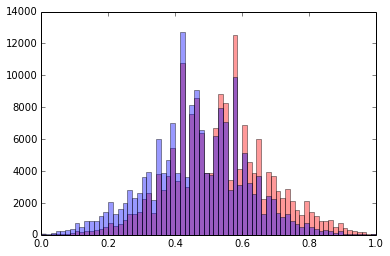

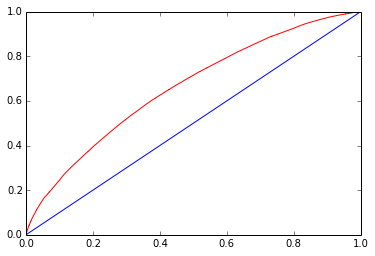

AUC 0.659420286458


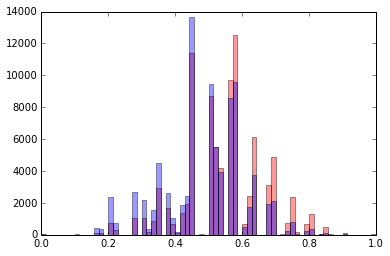

0.659124899309 1.08331796253e-06
KFold prediction using folds column
KFold prediction using folds column
0.550144612789
KFold prediction using folds column
KFold prediction using folds column
0.500772356987
KFold prediction using folds column
KFold prediction using folds column
0.567062854767
KFold prediction using folds column
KFold prediction using folds column
0.526184797287


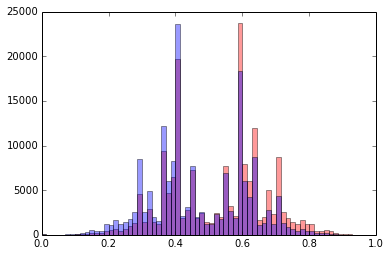

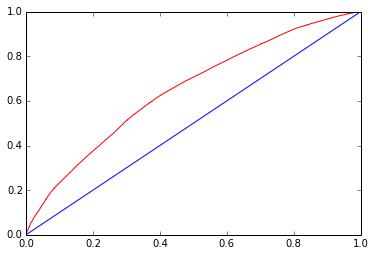

AUC 0.64957093144


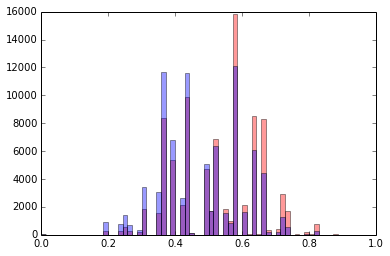

0.649244141925 1.52538544995e-06


In [42]:
results = []
results = results + combine("", "xgb_combined")
results = results + combine("_tmva", "tmva_combined")

In [43]:
pandas.concat(results)

,$D^2$,$\Delta D^2$,"$\Delta \epsilon, \%$","$\Delta \epsilon_{tag}, \%$",$\Delta w$,"$\epsilon, \%$","$\epsilon_{tag}, \%$",$w$,name
0,0.105638,0.000000,0.007012,0.066382,NaN,3.458053,32.734997,NaN,w/o calib xgb_combined
0,0.070458,0.000003,0.004678,0.066382,0.000006,2.306438,32.734997,0.488732,xgb_combined
0,0.090335,0.000000,0.005997,0.066382,NaN,2.957131,32.734997,NaN,w/o calib tmva_combined
0,0.061946,0.000010,0.004125,0.066382,0.000015,2.027798,32.734997,0.489087,tmva_combined
